# Reliability

## Evaluating the performance of a hybrid power plant including availability time series


In [1]:
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from hydesign.assembly.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath


### Reliability time series
It is important that the reliability time series is provided for the specific plant configuration. In this example we proved a realization of the reliability of 500W solar panels connected to 1MW inverters and we have 100 inverters. The PV-reliability time series is then the combined realiability of this setup. Here we assume that failing panels will be bypassed with bypass diodes.
The reliability time series provided for the wind turbines i for a realization with 50 turbines.

In [2]:
name = 'France_good_wind'
examples_sites = pd.read_csv(f'{examples_filepath}examples_sites.csv', index_col=0, sep=';')
ex_site = examples_sites.loc[examples_sites.name == name]

longitude = ex_site['longitude'].values[0]
latitude = ex_site['latitude'].values[0]
altitude = ex_site['altitude'].values[0]

sim_pars_fn = examples_filepath+ex_site['sim_pars_fn'].values[0]
input_ts_fn = examples_filepath+ex_site['input_ts_fn'].values[0]

reliability_ts_battery=pd.read_csv(os.path.join(examples_filepath, 'reliability', 'battery_seed_0.csv'), index_col=0, sep=',').values.squeeze()
reliability_ts_trans=pd.read_csv(os.path.join(examples_filepath, 'reliability', 'transformer_seed_0.csv'), index_col=0, sep=',').values.squeeze()
reliability_ts_wind=pd.read_csv(os.path.join(examples_filepath, 'reliability', 'wt_seed_0_50_turbines.csv'), index_col=0, sep=',').values.squeeze()
reliability_ts_pv=pd.read_csv(os.path.join(examples_filepath, 'reliability', 'pv_seed_0_100_inverters_of_1MW_500W_panels.csv'), index_col=0, sep=',').values.squeeze()

hpp = hpp_model(
        latitude,
        longitude,
        altitude,
        num_batteries = 10,
        work_dir = './',
        sim_pars_fn = sim_pars_fn,
        input_ts_fn = input_ts_fn,
        reliability_ts_battery=reliability_ts_battery,
        reliability_ts_trans=reliability_ts_trans,
        reliability_ts_wind=reliability_ts_wind,
        reliability_ts_pv=reliability_ts_pv,
)



Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0


C:\Users\mikf\Anaconda3\envs\sesame\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
wt_rated_power_MW = 4
surface_tilt_deg = 35
surface_azimuth_deg = 180
DC_AC_ratio = 1.5
Nwt = 50
wind_MW_per_km2 = 7
solar_MW = 100
b_P = 20
b_E_h  = 3
cost_of_batt_degr = 5
clearance = 20
sp = 350
D = np.sqrt(4 * wt_rated_power_MW * 10 ** 6 / np.pi / sp)
hh = clearance + D / 2

x = [# Wind plant design
    clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    # PV plant design
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    # Energy storage & EMS price constrains
    b_P, b_E_h, cost_of_batt_degr]


In [4]:
start = time.time()
outs = hpp.evaluate(*x)

hpp.print_design(x, outs)

end = time.time()
print('exec. time [min]:', (end - start)/60 )

print(hpp.prob['NPV_over_CAPEX'])


Design:
---------------
clearance [m]: 20.000
sp [W/m2]: 350.000
p_rated [MW]: 4.000
Nwt: 50.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 100.000
surface_tilt [deg]: 35.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 20.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 5.000


NPV_over_CAPEX: 0.054
NPV [MEuro]: 13.691
IRR: 0.064
LCOE [Euro/MWh]: 55.415
Revenues [MEuro]: 15.787
CAPEX [MEuro]: 253.070
OPEX [MEuro]: 3.777
Wind CAPEX [MEuro]: 153.566
Wind OPEX [MEuro]: 3.102
PV CAPEX [MEuro]: 33.500
PV OPEX [MEuro]: 0.675
Batt CAPEX [MEuro]: 6.451
Batt OPEX [MEuro]: 0.000
Shared CAPEX [MEuro]: 59.553
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 426.554
GUF: 0.162
grid [MW]: 300.000
wind [MW]: 200.000
solar [MW]: 100.000
Battery Energy [MWh]: 60.000
Battery Power [MW]: 20.000
Total curtailment [GWh]: 0.000
Total curtailment with deg [GWh]: 0.000
Awpp [km2]: 28.571
Apvp [km2]: 1.226
Plant area [km2]: 28.571
Rotor diam [m]: 120.6

### Transformer failure event example

In [5]:
trans_fail_index = int(np.argwhere(reliability_ts_trans==0)[0][0])

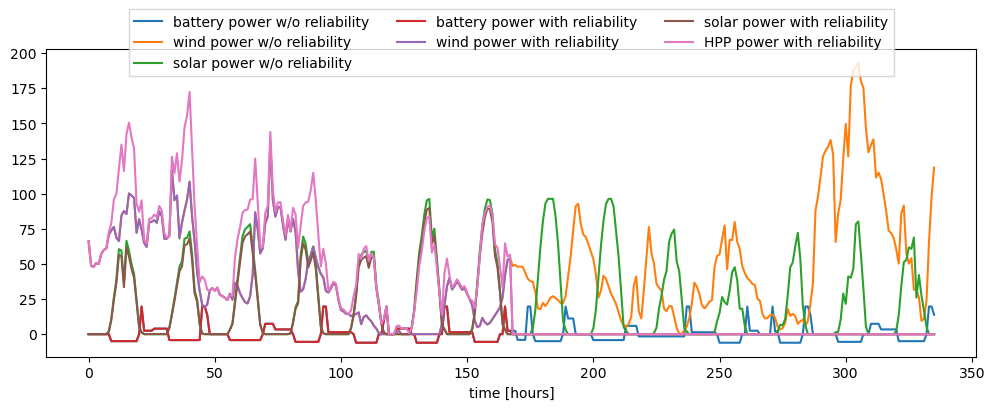

In [6]:
b_t = hpp.prob.get_val('battery_with_reliability.b_t')
wind_t = hpp.prob.get_val('wpp_with_reliability.wind_t')
solar_t = hpp.prob.get_val('pvp_with_reliability.solar_t')
b_t_rel = hpp.prob.get_val('battery_with_reliability.b_t_rel')
wind_t_rel = hpp.prob.get_val('wpp_with_reliability.wind_t_rel')
solar_t_rel = hpp.prob.get_val('pvp_with_reliability.solar_t_rel')
hpp_t = hpp.prob.get_val('ems_long_term_operation.hpp_t_with_deg')
grid_MW = hpp.prob.get_val('ems.G_MW')

n_days_plot = 14
idx_from = int(trans_fail_index-24*n_days_plot/2)
idx_to = int(trans_fail_index+24*n_days_plot/2)
plt.figure(figsize=[12,4])
plt.plot(b_t[idx_from:idx_to], label='battery power w/o reliability')
plt.plot(wind_t[idx_from:idx_to], label='wind power w/o reliability')
plt.plot(solar_t[idx_from:idx_to], label='solar power w/o reliability')
plt.plot(b_t_rel[idx_from:idx_to], label='battery power with reliability')
plt.plot(wind_t_rel[idx_from:idx_to], label='wind power with reliability')
plt.plot(solar_t_rel[idx_from:idx_to], label='solar power with reliability')
plt.plot(hpp_t[idx_from:idx_to], label='HPP power with reliability')
plt.xlabel('time [hours]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=3, fancybox=0, shadow=0)


## Generating availability time series
You can also generate your own availability data by supplying the mean time to fail and repair and probability distribution sampling constants:

In [7]:
from hydesign.reliability import generate_availability_ensamble
N_seeds = 2
inputs = {
    "WT": {"MTTF": 1.10e4,
            "MTTR": 1.10e2,
            "N_components": 200,              
            "sampling_const": 50.4,},
    "PV": {"MTTF": 3.53e4,
           "MTTR": 2.18e3,
           "N_components": 400*2,              
           "sampling_const": 1000},
    "inverter": {"MTTF": 3.01e4,
                 "MTTR": 7.20e2,
                 "N_components": 20,       
                 "sampling_const": 328.8},
    "transformer": {"MTTF": 1.77e4,
                    "MTTR": 6*30*24,
                    "N_components": 1,    
                    "sampling_const": 1972},
    "BESS": {"MTTF": 7.09e4,
             "MTTR": 1.68e2,
             "N_components": 1,           
             "sampling_const": 76.8}
    }
for k, v in inputs.items():
    ds_out = generate_availability_ensamble(component_name=k,
                                            MTTF = v['MTTF'],
                                            MTTR = v['MTTR'],
                                            N_components = v['N_components'],
                                            sampling_const = v['sampling_const'],
                                            seeds=range(N_seeds),
                                            )
    print(k)
    print(ds_out)


WT
<xarray.Dataset> Size: 129kB
Dimensions:          (sample: 20, component: 200, seed: 2)
Coordinates:
  * sample           (sample) int32 80B 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * component        (component) int32 800B 0 1 2 3 4 5 ... 195 196 197 198 199
    N_components     int32 4B 200
    ts_start         <U16 64B '2030-01-01 00:00'
    ts_end           <U16 64B '2054-12-31 23:00'
    ts_freq          <U2 8B '1h'
    N_sample         int32 4B 100407
    N_sample_needed  (seed) int32 8B 20 17
    component_name   <U2 8B 'WT'
  * seed             (seed) int32 8B 0 1
Data variables:
    TTF_indices      (seed, sample, component) float64 64kB 8.754e+03 ... nan
    TTR_indices      (seed, sample, component) float64 64kB 8.914e+03 ... nan
PV
<xarray.Dataset> Size: 258kB
Dimensions:          (sample: 10, component: 400, batch_no: 2, seed: 2)
Coordinates:
  * sample           (sample) int32 40B 0 1 2 3 4 5 6 7 8 9
  * component        (component) int32 2kB 0 1 2 3 4 5 ... 395 396 

These data sets can be converted to time series of availability. However these time series are memory intensive. The higher level HPP model for reliability can be used instead.
## Evaluation with HPP reliability model
This model will also run multiple realizations and aggregate the results together:

In [8]:
from hydesign.assembly.hpp_assembly_reliability import ReliabilityModel

In [9]:
n_reliability_seed = 2
inverter_size = 1000 #  [kW]
panel_size = 500 # [W]

x = [# Wind plant design
    clearance, sp, wt_rated_power_MW, Nwt, wind_MW_per_km2,
    # PV plant design
    solar_MW,  surface_tilt_deg, surface_azimuth_deg, DC_AC_ratio,
    # Energy storage & EMS price constrains
    b_P, b_E_h, cost_of_batt_degr,
    # Reliability inputs
    inverter_size, panel_size,
    ]

RM = ReliabilityModel(hpp_model,
           latitude=latitude,
           longitude=longitude,
           altitude=altitude,
           num_batteries = 10,
           sim_pars_fn = sim_pars_fn,
           input_ts_fn = input_ts_fn,
           n_reliability_seed=n_reliability_seed,
           )

start = time.time()
outs = RM.evaluate(*x)
end = time.time()
RM.print_design(x, outs)
print('exec. time [min]:', (end - start)/60 )


Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0

Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0

Fixed parameters on the site
-------------------------------
longitude = -0.864258
latitude = 48.744116
altitude = 302.0

Design:
---------------
clearance [m]: 20.000
sp [W/m2]: 350.000
p_rated [MW]: 4.000
Nwt: 50.000
wind_MW_per_km2 [MW/km2]: 7.000
solar_MW [MW]: 100.000
surface_tilt [deg]: 35.000
surface_azimuth [deg]: 180.000
DC_AC_ratio: 1.500
b_P [MW]: 20.000
b_E_h [h]: 3.000
cost_of_battery_P_fluct_in_peak_price_ratio: 5.000
inverter_size [kW]: 1000.000
panel_size [W]: 500.000


NPV_over_CAPEX: 0.333
NPV [MEuro]: 84.239
IRR: 0.086
LCOE [Euro/MWh]: 45.168
Revenues [MEuro]: 19.405
CAPEX [MEuro]: 253.070
OPEX [MEuro]: 3.777
Wind CAPEX [MEuro]: 153.566
Wind OPEX [MEuro]: 3.102
PV CAPEX [MEuro]: 33.500
PV OPEX [MEuro]: 0.675
Batt CAPEX [MEuro]